In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import warnings
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

car_prices_array = [3,4,5,6,7,8,9]
car_price_np = np.array(car_prices_array,dtype=np.float32)
car_price_np = car_price_np.reshape(-1,1)
car_price_tensor = Variable(torch.from_numpy(car_price_np))

# lets define number of car sell
number_of_car_sell_array = [ 7.5, 7, 6.5, 6.0, 5.5, 5.0, 4.5]
number_of_car_sell_np = np.array(number_of_car_sell_array,dtype=np.float32)
number_of_car_sell_np = number_of_car_sell_np.reshape(-1,1)
number_of_car_sell_tensor = Variable(torch.from_numpy(number_of_car_sell_np))


class LinearRegression(nn.Module):
    def __init__(self,input_size,output_size):
        super(LinearRegression,self).__init__()
        self.linear=nn.Linear(input_size,output_size)

    def forward(self,x):
        return self.linear(x)

input_dim=1
output_dim=1
model=LinearRegression(input_dim,output_dim)
mse=nn.MSELoss()

learning_rate=0.02
optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)

loss_list=[]
iteration_number=1001

for x in range(iteration_number):
    optimizer.zero_grad()
    results=model(car_price_tensor)
    loss=mse(results,number_of_car_sell_tensor)
    loss.backward()
    optimizer.step()
    loss_list.append(loss.data)

    if (x%50==0):
        print('epoch {}, losss{}'.format(x,loss.data))



epoch 0, losss37.70454025268555
epoch 50, losss5.301415920257568
epoch 100, losss3.5823886394500732
epoch 150, losss2.4207701683044434
epoch 200, losss1.6358164548873901
epoch 250, losss1.1053884029388428
epoch 300, losss0.7469572424888611
epoch 350, losss0.5047509074211121
epoch 400, losss0.3410806655883789
epoch 450, losss0.2304825633764267
epoch 500, losss0.155747190117836
epoch 550, losss0.10524462163448334
epoch 600, losss0.07111850380897522
epoch 650, losss0.04805785417556763
epoch 700, losss0.032474882900714874
epoch 750, losss0.021944690495729446
epoch 800, losss0.014828731305897236
epoch 850, losss0.010020410642027855
epoch 900, losss0.006771299988031387
epoch 950, losss0.004575683735311031
epoch 1000, losss0.003091980004683137


<h1>Digit Classification with Pytorch</h1>

In [7]:
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split


batch_train_size=64
batch_test_size=1000
learning_rate=0.01
momentum=0.5
log_interval=10
n_epochs=3
random_seed=1
torch.backends.cudnn.enabled=True
torch.manual_seed(random_seed)

train_loader=DataLoader(
    torchvision.datasets.MNIST('files/',train=True,download=True,
                              transform=torchvision.transforms.Compose(
                                  [
                                      torchvision.transforms.ToTensor(),
                                      torchvision.transforms.Normalize(
                                          (0.1307,),(0.3081,)
                                      )
                                  ]
                              )),
    batch_size=batch_train_size,shuffle=True)
test_loader=DataLoader(
    torchvision.datasets.MNIST(
        'files/',train=False,download=True,
        transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                (0.1307,),(0.3081,)
            )
        ])
    ),
    batch_size=batch_test_size,shuffle=True
)

examples=enumerate(test_loader)
batch_idx,(example_data,example_targets)=next(examples)

In [8]:
examples

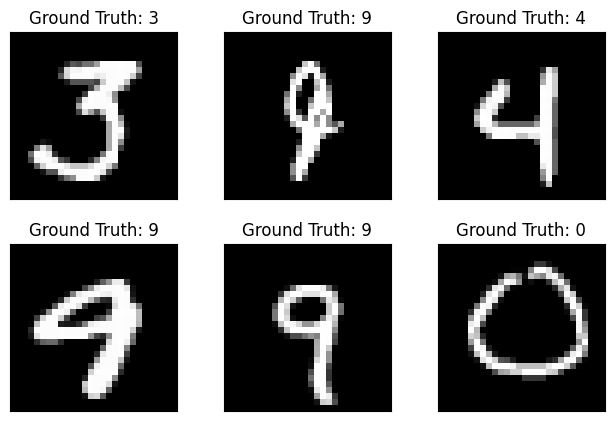

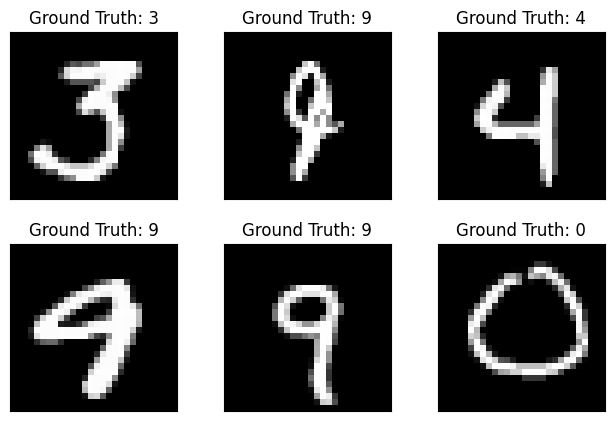

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [31]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.cov1=nn.Conv2d(1,10,kernel_size=5)
        self.cov2=nn.Conv2d(10,20,kernel_size=5)
        self.cov2_drop=nn.Dropout2d()
        self.fc1=nn.Linear(320,50)
        self.fc2=nn.Linear(50,10)
    def forward(self,x):
        x=F.relu(F.max_pool2d(self.cov1(x),2))
        x=F.relu(F.max_pool2d(self.cov2_drop(self.cov2(x)),2))
        x=x.view(-1,320)
        x=F.relu(self.fc1(x))
        x=F.dropout(x,training=self.training)
        x=self.fc2(x)
        return F.log_softmax(x)
             

In [32]:
network=Net()
optimizer=optim.SGD(network.parameters(),lr=learning_rate,momentum=momentum)

In [23]:
train_losses=[]
train_counter=[]
test_losses=[]
test_counter=[i*len(train_loader.dataset) for i in range(n_epochs+1)]

In [45]:
def train(epoch):
    network.train()
    for batch_idx,(data,target) in enumerate(train_loader):
        optimizer.zero_grad()
        output=network(data)
        loss=F.nll_loss(output,target)
        loss.backward()
        optimizer.step()
        if batch_idx%log_interval==0:
            print('Train Epoch {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
                epoch,batch_idx * len(data),len(train_loader.dataset),
                100. * batch_idx/len(train_loader),loss.item()
            ))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64)+((epoch-1)*len(train_loader.dataset))
            )
            torch.save(network.state_dict(),'results/model.pth')
            torch.save(optimizer.state_dict(),'results/optimizer.pth')
            

In [34]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [46]:
test()
for epoch in range(1,n_epochs+1):
    train(epoch)
    test()
    


Test set: Avg. loss: 2.3094, Accuracy: 1034/10000 (10%)

Train Epoch 1 [0/60000 (0%)]	 Loss: 2.274286
Train Epoch 1 [640/60000 (1%)]	 Loss: 2.290798
Train Epoch 1 [1280/60000 (2%)]	 Loss: 2.290930
Train Epoch 1 [1920/60000 (3%)]	 Loss: 2.265378
Train Epoch 1 [2560/60000 (4%)]	 Loss: 2.180207
Train Epoch 1 [3200/60000 (5%)]	 Loss: 2.218233
Train Epoch 1 [3840/60000 (6%)]	 Loss: 2.186538
Train Epoch 1 [4480/60000 (7%)]	 Loss: 2.135159
Train Epoch 1 [5120/60000 (9%)]	 Loss: 2.089348
Train Epoch 1 [5760/60000 (10%)]	 Loss: 1.984524
Train Epoch 1 [6400/60000 (11%)]	 Loss: 2.015962
Train Epoch 1 [7040/60000 (12%)]	 Loss: 1.688340
Train Epoch 1 [7680/60000 (13%)]	 Loss: 1.823223
Train Epoch 1 [8320/60000 (14%)]	 Loss: 1.676763
Train Epoch 1 [8960/60000 (15%)]	 Loss: 1.439182
Train Epoch 1 [9600/60000 (16%)]	 Loss: 1.332053
Train Epoch 1 [10240/60000 (17%)]	 Loss: 1.404745
Train Epoch 1 [10880/60000 (18%)]	 Loss: 1.301847
Train Epoch 1 [11520/60000 (19%)]	 Loss: 1.160593
Train Epoch 1 [12160/

Text(0, 0.5, 'negative log likelihood loss')

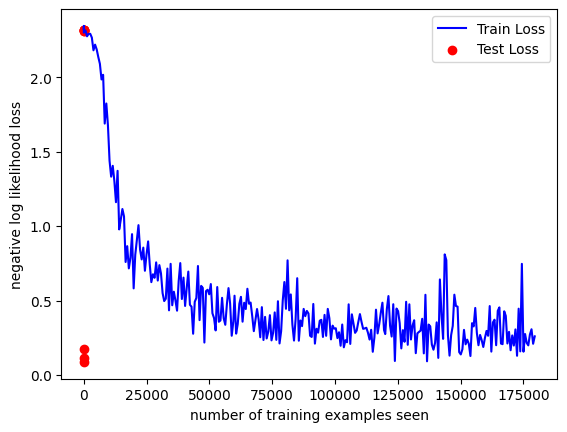

In [64]:
fig = plt.figure()
plt.plot(train_counter, train_losses[:284], color='blue')
plt.scatter(range(0,9), test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')